In [1]:
import pandas as pd
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# load
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

# dropping columns with no iteration
train = train.drop(['keyword', 'location'], axis=1)
test = test.drop(['keyword', 'location'], axis=1)


In [2]:

def stopwords(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    palavras = [i for i in text.split() if not i in stopwords]
    return (" ".join(palavras))

def remove_carac(text):
    text = text.str.lower() 
    text = text.str.replace(r"\#","") 
    text = text.str.replace(r"http\S+","")  
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^a-zA-Z#]", " ")
    text = text.str.replace("\s{2,}", "")
    return text

train['text'] = [stopwords(i) for i in train['text']]
train['text'][:10]

test['text'] = [stopwords(i) for i in test['text']]

train['clean_text'] = remove_carac(train['text'])

test['clean_text'] = remove_carac(test['text'])

train['clean_text'][:10]


<ipython-input-2-5964401375eb>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"\#","")
<ipython-input-2-5964401375eb>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"http\S+","")
<ipython-input-2-5964401375eb>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"[^a-zA-Z#]", " ")
<ipython-input-2-5964401375eb>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace("\s{2,}", "")


0     our deeds reason earthquake may allah forgive us
1                 forest fire near la ronge saskcanada
2    all residents askedshelter placenotified offic...
3    people receive wildfires evacuation orders cal...
4    just got sent photo ruby alaska smoke wildfire...
5    rockyfire updatecalifornia hwyclosed direction...
6    flood disaster heavy rain causes flash floodin...
7                        i m top hill i see fire woods
8    there s emergency evacuation happening buildin...
9                       i m afraid tornado coming area
Name: clean_text, dtype: object

In [4]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def lemmatization(texto):
    palavras = []
    for w in texto.split():
        palavras.append(lem.lemmatize(w))
    return (" ".join(palavras))

train['clean_text'] = [lemmatization(f) for f in train['clean_text']]
train['clean_text'][:10]

test['clean_text'] = [lemmatization(f) for f in test['clean_text']]

[nltk_data] Downloading package wordnet to /Users/sonali/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
from nltk.stem.snowball import SnowballStemmer

def stemming(texto):
    stemmer = SnowballStemmer(language='english')
    palavras = []
    for w in texto.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

train['clean_text'] = [stemming(t) for t in train['clean_text']]

test['clean_text'] = [stemming(t) for t in test['clean_text']]

train['clean_text'][:10]

# droping the 'text' column and organizing
train = train.drop(['text'], axis=1)
train = train.reindex(columns=['clean_text', 'target'])

test = test.drop(['text'], axis=1)

In [6]:
# concat the train and test dataset first
df = pd.concat([train,test], ignore_index=True)

# droping the words with less than 3 letters for plot
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,clean_text,target,id
0,deed reason earthquak allah forgiv,1.0,NaN
1,forest fire near rong saskcanada,1.0,NaN
2,resid askedshelt placenotifi officersno evacu ...,1.0,NaN
3,peopl receiv wildfir evacu order california,1.0,NaN
4,just sent photo rubi alaska smoke wildfir pour...,1.0,NaN


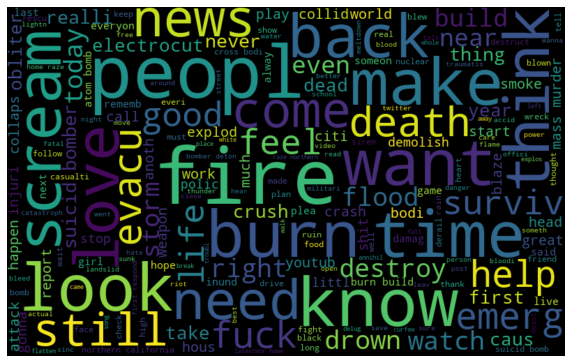

In [7]:
# Using the WordCloud to see the frequency of the words
from wordcloud import WordCloud

palavras = ' '.join([text for text in df['clean_text']])

wordcloud = WordCloud(width=800, height = 500, max_font_size=110).generate(palavras)

# plotting
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

fig1 = plt.gcf()
fig1.savefig('words.png')
plt.show()

In [14]:
# roBERTa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
import tqdm

# changing the device to GPU
device = torch.device('cpu')  #('cuda:0')

# using the roBERTa model
roberta_weights = 'roberta-base'
roberta_model = transformers.RobertaModel.from_pretrained(roberta_weights).to(device)
roberta_token = transformers.RobertaTokenizer.from_pretrained(roberta_weights)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# tokenizing the clean_text column on train dataset
tokenized = [torch.tensor(roberta_token.encode(i)).unsqueeze(0).to(device) for i in train['clean_text']]

embeddings = []

roberta_model.eval()  # the eval lock the model and stop training
with torch.no_grad(): # aplying non-training to torch
    for x in tqdm.notebook.tqdm(tokenized):  # tqdm is a progress bar
        embeddings.append(roberta_model(x)[1].cpu().numpy())  # changing the device to cpu for interation with sklearn
        
# transforming the embeddings list to a array of arrays
embeddings_numpy = np.array(embeddings).squeeze()

embeddings_numpy.shape

  0%|          | 0/7613 [00:00<?, ?it/s]

(7613, 768)

In [21]:
from sklearn import model_selection, metrics
# defining the features and target
X = embeddings_numpy
y = train['target']

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)

from sklearn.model_selection import RepeatedKFold

kf = RepeatedKFold(n_splits= 2, n_repeats=10, random_state=42)


for train_lines, valid_lines in kf.split(X):
    X_train, X_valid = X[train_lines], X[valid_lines]
    y_train, y_valid = y[train_lines], y[valid_lines]
    
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(boosting_type= 'gbdt', objective='binary', learning_rate= 0.1, random_state=42, class_weight='balanced', num_leaves=32)
lgbm.fit(X_train, y_train)

predValues = lgbm.predict(X_valid)
print(classification_report(y_valid, lgbm.predict(X_valid)))
test_acc = metrics.accuracy_score(predValues, y_valid)
print("Test Accuracy: ", test_acc)
print("Test F-score: ", metrics.f1_score(y_valid, predValues))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      2152
           1       0.76      0.67      0.71      1654

    accuracy                           0.76      3806
   macro avg       0.76      0.75      0.76      3806
weighted avg       0.76      0.76      0.76      3806

Test Accuracy:  0.7640567524960589
Test F-score:  0.712915601023018


In [18]:
tokenized_test = [torch.tensor(roberta_token.encode(i)).unsqueeze(0).to(device) for i in test['clean_text']]

test_embeddings = []

roberta_model.eval()  # the eval lock the model and stop training
with torch.no_grad(): # aplying non-training to torch
    for x in tqdm.notebook.tqdm(tokenized_test):  # tqdm is a progress bar
        test_embeddings.append(roberta_model(x)[1].cpu().numpy())  # changing the device to cpu for interation with sklearn
        
test_embeddings_numpy = np.array(test_embeddings).squeeze()

test_embeddings_numpy.shape

# predicting the test
features = test_embeddings_numpy

pred = lgbm.predict(features)

sub_sample = pd.read_csv("sample_submission.csv")
submit = sub_sample.copy()
submit.target = pred
submit.to_csv('sample_submission.csv',index=False)

  0%|          | 0/3263 [00:00<?, ?it/s]